In [3]:
# from google.colab import drive
# drive.mount("/content/drive")

# !mkdir -p ~/.kaggle
# !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d sharansmenon/animals141

# import zipfile
# with zipfile.ZipFile("animals141.zip","r") as zip:
#   zip.extractall("animal")



from torchvision import transforms

augmentation=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

dataset=r"C:\Users\Arun\Downloads\dataset\dataset"
training_data = ImageFolder(root=dataset,transform=augmentation)

train_size=int(0.7*len(training_data))
val_size=len(training_data)-train_size

from torch.utils.data import random_split

train_data,val_data=random_split(training_data,[train_size,val_size])

train_loader=DataLoader(train_data,shuffle=True,batch_size=712,num_workers=2)
val_loader=DataLoader(val_data,batch_size=712,num_workers=2)

from torch import nn

class animal_cnn(nn.Module):
  def __init__(self,num_classes=151):
    super(animal_cnn,self).__init__()
    self.feature=nn.Sequential(
    nn.Conv2d(3,32,3,padding=1),nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(32,64,3,padding=1),nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(64,128,3,padding=1),nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(128,256,3,padding=1),nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(256*8*8,256),
    nn.Dropout(0.25),
    nn.Linear(256,num_classes),
    )
  def forward(self,x):
    x = self.feature(x)
    return x

import torch

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model=animal_cnn(num_classes=151).to(device)
model_loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model.parameters(),lr=0.001)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optim,mode="min",patience=2,factor=0.5)




cuda


In [4]:
class earlystopping():
  def __init__(self,min_delta,patience=3):
    self.patience=patience
    self.min_delta=min_delta
    self.early_stop=False
    self.best_loss=float("inf")
    self.counter=0

  def __call__(self,val_loss):
    if val_loss < self.best_loss - self.min_delta:
      self.best_loss=val_loss
      self.counter=0
    else:
      self.counter+=1
      if self.counter>=self.patience:
        self.early_stop=True


In [5]:
from torch.amp import GradScaler, autocast

scaler = GradScaler(device="cuda")
epochs=50
training_loss=[]
accuracy=[]
val_losses=[]
val_accuracy=[]
earlystopping_callback=earlystopping(min_delta=0.0004,patience=5)
for epoch in range(epochs):
    model.train()
    running_loss = 0
    mcorrect, mtotal = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optim.zero_grad()
        with autocast(device_type="cuda"):
            outputs = model(images)
            loss = model_loss(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        mcorrect += (preds == labels).sum().item()
        mtotal += labels.size(0)

    train_loss = running_loss / len(train_loader)
    acc = 100 * mcorrect / mtotal
    training_loss.append(train_loss)
    accuracy.append(acc)

    model.eval()
    val_running_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with autocast(device_type="cuda"): 
                outputs = model(images)
                v_loss = model_loss(outputs, labels)

            val_running_loss += v_loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_running_loss / len(val_loader)
    scheduler.step(val_loss)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc={acc:.2f}%, Train Loss={train_loss:.4f} | Val Acc={val_acc:.2f}%, Val Loss={val_loss:.4f}")

    earlystopping_callback(val_loss)
    if earlystopping_callback.early_stop:
        print("Early stopping triggered")
        break


Epoch 1: Train Acc=0.77%, Train Loss=5.0152 | Val Acc=1.12%, Val Loss=5.0140


KeyboardInterrupt: 

In [ ]:
names={"equus-quagga": "Plains Zebra", "panthera-leo": "Lion", "panthera-onca": "Jaguar", "ursus-arctos-horribilis": "Grizzly Bear", "megaptera-novaeangliae": "Humpback Whale", "panthera-tigris": "Tiger", "haliaeetus-leucocephalus": "Bald Eagle", "tyrannosaurus-rex": "T. Rex", "diplodocus": "Diplodocus", "panthera-pardus": "Leopard", "homo-sapiens": "Modern Humans", "phoebetria-fusca": "Sooty Albatross", "bos-taurus": "Domestic Cow", "gallus-gallus-domesticus": "Chicken", "ovis-aries": "Sheep", "ceratotherium-simum": "White Rhino", "loxodonta-africana": "African Bush Elephant", "tursiops-truncatus": "Common Bottlenose Dolphin", "orcinus-orca": "Killer Whale", "carcharodon-carcharias": "Great White Shark", "canis-lupus-familiaris": "Domestic Dog", "felis-catus": "Cat", "salmo-salar": "Salmon", "balaenoptera-musculus": "Blue Whale", "giraffa-camelopardalis": "Northern Giraffe", "ophiophagus-hannah": "King Cobra", "crotalus-atrox": "Western diamondback rattlesnake", "varanus-komodoensis": "Komodo Dragon", "pterois-mombasae": "African Lionfish", "spinosaurus-aegyptiacus": "Spinosaurus", "crocodylus-niloticus": "Crocodile", "falco-peregrinus": "Peregrine Falcon", "gorilla-gorilla": "Gorilla", "pongo-abelii": "Orangutan", "gavialis-gangeticus": "Gharial", "acinonyx-jubatus": "Cheetah", "canis-lupus": "Wolf", "ursus-maritimus": "Polar Bear", "hippopotamus-amphibius": "Hippopotamus", "iguana-iguana": "Green Iguana", "iguanodon-bernissartensis": "Iguanadon", "stegosaurus-stenops": "Stegosaurus", "triceratops-horridus": "Triceratops", "pteranodon-longiceps": "Pteranodon", "ankylosaurus-magniventris": "Ankylosaurus", "agalychnis-callidryas": "Tree Frog", "dendrobatidae": "Poison Dart Frog", "mellisuga-helenae": "Bee Hummingbird", "eudocimus-albus": "American white ibis", "sphyrna-mokarran": "Great hammerhead shark", "trilobita": "Trilobites", "enteroctopus-dofleini": "Giant Pacific octopus", "coelacanthiformes": "Coelacanth", "equus-caballus": "Horse", "odobenus-rosmarus": "Walrus", "physeter-macrocephalus": "Sperm Whale", "dugong-dugon": "Dugong", "eunectes-murinus": "Green Anaconda", "malayopython-reticulatus": "Reticulated Python", "rattus-rattus": "Black Rat", "ornithorhynchus-anatinus": "Platypus", "desmodus-rotundus": "Vampire Bat", "taurotragus-oryx": "Common Eland", "connochaetes-gnou": "Wildebeest", "puma-concolor": "Cougar", "formicidae": "Ant", "danaus-plexippus": "Monarch Butterfly", "papilio-glaucus": "Eastern Tiger Swallowtail", "heterocera": "Moth", "dermochelys-coriacea": "Leatherback Sea Turtle", "lampropeltis-triangulum": "Milk snake", "heloderma-suspectum": "Gila Monster", "macropus-giganteus": "Kangaroo", "ailuropoda-melanoleuca": "Giant Panda", "ailurus-fulgens": "Red Panda", "procyon-lotor": "Raccoon", "smilodon-populator": "Smilodon", "mammuthus-primigeniu": "Woolly Mammoth", "tapirus": "Tapir", "bison-bison": "American Bison", "alces-alces": "Moose", "aptenodytes-forsteri": "Emperor Penguin", "hydrurga-leptonyx": "Leopard Seal", "bradypus-variegatus": "Brown-throated Three-toed Sloth", "sciurus-carolinensis": "Eastern Gray Squirrel", "cyanocitta-cristata": "Blue Jay", "periplaneta-americana": "American Cockroach", "anas-platyrhynchos": "Mallard", "pavo-cristatus": "Indian Peafowl", "ara-macao": "Scarlet Macaw", "enhydra-lutris": "Sea Otter", "physalia-physalis": "Portuguese Man o' War", "codium-fragile": "Dead Man's Fingers", "centruroides-vittatus": "Striped Bark Scorpion", "lemur-catta": "Ring-tailed Lemur", "delphinapterus-leucas": "Beluga", "inia-geoffrensis": "Boto", "phascolarctos-cinereus": "Koala", "spheniscus-demersus": "African Penguin", "aquila-chrysaetos": "Golden Eagle", "branta-canadensis": "Canada Goose", "turdus-migratorius": "American Robin", "passerina-ciris": "Painted Bunting", "geococcyx-californianus": "Greater Roadrunner", "icterus-galbula": "Baltimore Oriole", "icterus-spurius": "Orchard Oriole", "crotophaga-sulcirostris": "Groove-billed Ani", "monodon-monoceros": "Narwhal", "struthio-camelus": "Common Ostrich", "ardea-herodias": "Great Blue Heron", "phoenicopterus-ruber": "American Flamingo", "okapia-johnstoni": "Okapi", "cryptoprocta-ferox": "Fossa", "cardinalis-cardinalis": "Northern Cardinal", "apis-mellifera": "Western Honey Bee", "telmatobufo-bullocki": "Bullock Mountains False Toad", "architeuthis-dux": "Giant Squid", "agkistrodon-contortrix": "Eastern Copperhead", "eidolon-helvum": "Straw-coloured Fruit Bat", "ceratitis-capitata": "Mediterranean Fruit Fly", "musca-domestica": "Common House Fly", "thryothorus-ludovicianus": "Carolina Wren", "rusa-unicolor": "Sambar", "bos-gaurus": "Gaur", "vultur-gryphus": "Andean Condor", "aethia-cristatella": "Crested Auklet", "mimus-polyglottos": "Northern Mockingbird", "cathartes-aura": "Turkey Vulture", "poecile-atricapillus": "Black-capped Chickadee", "mergus-serrator": "Red-breasted Merganser", "colaptes-auratus": "Northern Flicker", "circus-hudsonius": "Northern Harrier", "tyrannus-tyrannus": "Eastern Kingbird", "betta-splendens": "Siamese Fighting Fish", "pterois-volitans": "Common Lionfish", "phyllobates-terribilis": "Golden Poison Dart Frog", "hapalochlaena-maculosa": "Lesser Blue-ringed Octopus", "ovis-canadensis": "Bighorn Sheep", "vulpes-vulpes": "Red Fox", "lepus-americanus": "Snowshoe Hare", "dasypus-novemcinctus": "Nine-banded Armadillo", "martes-americana": "American Marten", "tarsius-pumilus": "Pygmy Tarsier", "melanerpes-carolinus": "Red-bellied Woodpecker", "icterus-gularis": "Altamira Oriole", "chelonia-mydas": "Green Sea Turtle", "chrysemys-picta": "Painted Turtle", "pantherophis-guttatus": "Corn Snake", "correlophus-ciliatus": "Crested Giant Gecko", "centrochelys-sulcata": "African Spurred Tortoise", "pantherophis-alleghaniensis": "Eastern Ratsnake"}

NameError: name 'transforms' is not defined

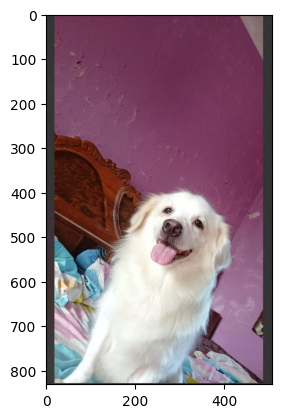

In [ ]:
from PIL import Image

new_image=Image.open(r"image_converted1.jpg")

import matplotlib.pyplot as plt
plt.imshow(new_image)

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

new_image_tensor =(transform(new_image).unsqueeze(0)).to(device)

model.eval()
with torch.no_grad():
  out=model(new_image_tensor)
  idx=torch.max(out,1).indices.item()
name=training_data.classes[idx]
for i in names:
  if i==name:
    print(names[i])


In [ ]:
from PIL import Image
import os

# PNG image path
png_path = r"C:\Users\Arun\OneDrive\Pictures\Screenshots 1\Screenshot 2025-08-01 020521.png"

# Load the PNG image
img = Image.open(png_path).convert("RGB")  # RGB convert zaroori hai for JPEG

# Output JPG path
jpg_path = "image_converted1.jpg"

# Save as JPG
img.save(jpg_path, "JPEG")

print("Conversion done:", jpg_path)


Conversion done: image_converted1.jpg
